# Samlping from a transformed parameter space

This example shows you how to run (and compare) Bayesian inference using a transformed parameter space.

Searching in a transformed space can improve performance (and robustness) of many sampling methods, and make some methods applicable to problems that cannot otherwise be tackled.

We start by loading a ``pints.Forwardmodel`` implementation, in this case a [logistic model](https://pints.readthedocs.io/en/latest/toy/logistic_model.html).

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Set some random seed so this notebook can be reproduced
np.random.seed(10)

# Load a forward model
model = toy.LogisticModel()

We then define some parameters and set up the problem for the Bayesian inference.

In [2]:
# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.001, 10, noise*0.1],
    [1.0, 1000, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In this example, we will pick some considerably difficult starting points for the MCMC chains.

In [3]:
# Choose starting points for 3 mcmc chains
xs = [
    [0.7, 20, 2],
    [0.005, 900, 100],
    [0.01, 100, 500],
]

Let's run an [Adaptive Covariance MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/haario_bardenet_ac_mcmc.html) without doing any parameter transformation to check its performance.

Running...
Done!


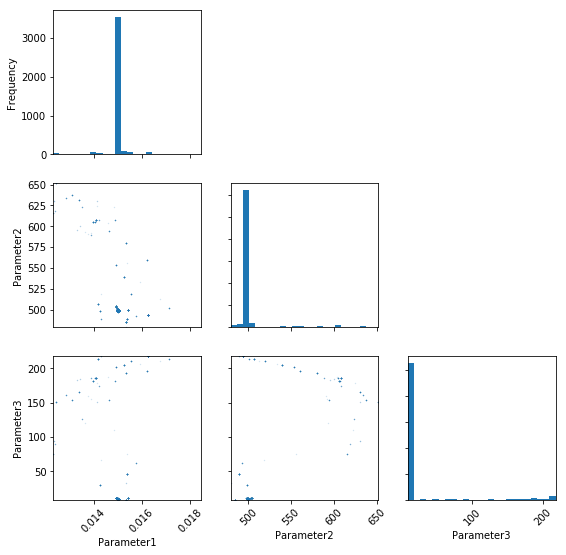

In [4]:
# Create mcmc routine with four chains
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Create a timer to time the method
timer = pints.Timer()

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Get the time since the timer was created
time_taken = timer.time()

# Discard warm up
chains = chains[:, 2000:, :]

# Look at distribution across all chains
pints.plot.pairwise(np.vstack(chains), kde=False)

# Show graphs
plt.show()

We can use [MCMCSummary](https://pints.readthedocs.io/en/latest/mcmc_samplers/summary_mcmc.html) to inspect the efficiency of the MCMC run.

In [5]:
results = pints.MCMCSummary(chains=chains, time=time_taken, parameter_names=["r", "k", "sigma"])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
r        0.02    0.00    0.01    0.02    0.02    0.02    0.02     1.00    374.60  83.49
k        503.22  20.97   493.34  498.84  499.22  499.56  604.65   1.13    333.04  74.23
sigma    21.72   45.46   8.97    9.26    9.42    9.61    205.08   1.30    357.35  79.65


Now, we create a log-transformation object and re-run the MCMC to see if it makes any difference.

Running...
Done!


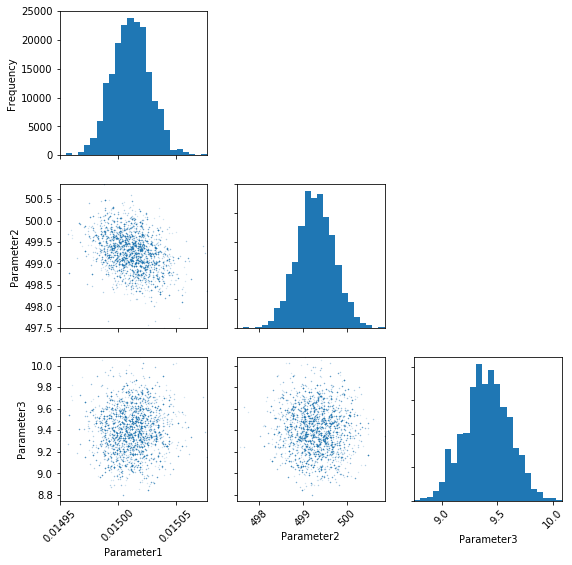

In [6]:
# Create parameter transformation
transform = pints.LogTransform(len(xs[0]))

# Create mcmc routine with four chains
mcmc = pints.MCMCController(log_posterior, 3, xs,
                            method=pints.HaarioBardenetACMC,
                            transform=transform)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Restart the timer
timer.reset()

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Get the time taken
time_taken = timer.time()

# Discard warm up
chains = chains[:, 2000:, :]

# Look at distribution across all chains
pints.plot.pairwise(np.vstack(chains), kde=False)

# Show graphs
plt.show()

The MCMC samples in the above plot looks very similar to the one without parameter transformation when we had some good starting points in [here](./adaptive-covariance-haario-bardenet.ipynb), which is a good sign!
(It suggests the transformation did not mess anything up.)

Now we check the efficiency again:

In [7]:
results = pints.MCMCSummary(chains=chains, time=time_taken, parameter_names=["r", "k", "sigma"])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
r        0.02    0.00    0.01    0.02    0.02    0.02    0.02     1.00    478.59  97.37
k        499.28  0.42    498.44  499.01  499.28  499.56  500.11   1.01    542.32  110.34
sigma    9.40    0.20    9.02    9.26    9.40    9.54    9.79     1.01    511.25  104.02


With the log-transformation on the parameters, even when using the same data and the same initial positions, we get much better performance than in the untransformed case.